## **Business Understanding**

This project aims to effectively analyze and predict arrest outcomes of Terry Stops that have been conducted by the Seattle Police Department. It mainly focuses on whether a stop will result in a formal arrest or not. By leveraging features such as the time of day, precinct location, subject demographics and the presence of weapons, the model seeks to uncover the key drivers behind police decision-making for any given traffic stop. This will not only provide law enforcement agencies with insights into operational patterns and resource allocation, but also offer stakeholders and policymakers a data-driven lens to evaluate the consistency, transparency and factors that influence police interventions.

## **Data Understanding**

The [dataset](Data/Terry_Stops_20251229.csv) consists of 65,931 records and 23 features that comprehensively represent Terry Stops reported by the Seattle Police Department. Each row represents a unique police stop incident.

Key Features: The features can be categorized into four main groups:

 * **Subject Demographics**: Attributes describing the individual(s) who have been stopped by an officer and they include but not limited to: `Subject Age Group`, `Subject Perceived Race` and `Subject Perceived Gender`.

 * **Officer Demographics**: These are attributes describing the officer involved; such as `Officer ID`, `Officer Gender`, `Officer Race` and `Officer Year of Birth`.

 * **Event Details**: Contextual information about the stop, including `Reported Date`, `Occurred Date`, `Precinct`, `Sector` and `Beat`.

* **Operational Factors**: Police procedure details such as `Initial Call Type`, `Final Call Type`, `Frisk Flag` and `Weapon Type`.  


<br>

The target variable will be `Arrest Flag`, which is a binary indicator showing whether the stop resulted in a physical arrest (Y) or not (N). This variable is thus significant and valuable for our classification task at hand.

<br>
The distribution of the dataset is highly imbalanced. This is because:

  * No Arrest (N): ~89% of cases (58,368 stops)

  * Arrest (Y): ~11% of cases (7,563 stops)

The model must account for this imbalance to prevent it from simply predicting "No Arrest" every time to achieve high accuracy.

<br>
In terms of the data quality, the following were some of the notable observations:

 1. **Missing Values**: The `Weapon Type` column contains a significant number of missing values which may indicate that no weapon was involved.

 2. **Placeholder Values**: Several columns contain placeholder characters like `-` or `Unknown`, which require cleaning during the preprocessing stage.

 3. **Categorical Complexity**: Features like `Call Type` and `Final Call Type` have high cardinality (many unique text values), requiring grouping or dimensionality reduction for effective modeling.

4. **Subject ID Issues**: A large number of records have a Subject ID of -1, indicating that many subjects were not uniquely identified or linked to a master record system.

In [421]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report,  roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [422]:
# Loading the dataset
df_raw = pd.read_csv('Data/Terry_Stops_20251229.csv')
df_raw.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Occurred Date
0,1 - 17,-1,20170000317010,301638,Arrest,None,7773,1978,Male,White,...,OBS - FIGHT - IP - PHYSICAL (NO WEAPONS),"ASSAULTS, OTHER",911,NORTH PCT 3RD W - B/N RELIEF,N,N,North,L,L3,2017-08-27T03:18:00
1,26 - 35,7752588737,20240000337534,61254189481,Offense Report,-,8584,1982,Male,White,...,BURG - COMM BURGLARY,WARRANT SERVICES - MISDEMEANOR,ONVIEW,SOUTH PCT 1ST W - SAM - PLATOON 2,N,N,South,O,O1,2024-11-30T05:20:00
2,56 and Above,-1,20190000057245,532414,Arrest,None,8606,1965,Female,White,...,ASLT - WITH OR W/O WPNS (NO SHOOTINGS),"ASSAULTS, OTHER",911,TRAINING - FIELD TRAINING SQUAD,N,N,West,M,M3,2019-02-15T13:15:00
3,26 - 35,-1,20180000002293,434590,Field Contact,None,8022,1990,Male,Hispanic,...,-,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,2018-06-24T18:49:00
4,36 - 45,7727706299,20250000063255,63109655222,Field Contact,-,8974,1997,Female,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NORTH PCT 2ND W - BOY (JOHN) - PLATOON 1,N,N,North,U,U2,2025-03-08T17:58:00


### **Exploratory Data Analysis**

1. **Data Quality Check**

The [Dataset](Data/Terry_Stops_20251229.csv) contains a total of 65,931 stops records and 23 columns with no duplicate entries within the entire dataset.

However, there were notable instances of missing data such as: 

 * Weapon Type: This likely means that there were "No Weapons" or "Not Recorded".

 * Officer Squad: A small number (566) are missing.


Imbalance: The target variable `Arrest Flag` is highly imbalanced with about 88.5% of stops resulting in no arrest ('N') while 11.5% resulted in an arrest ('Y').


2. **Univariate Analysis**

Subject Demographics:

Age: The most frequently stopped age group is 26-35, followed by 36-45 and 18-25.

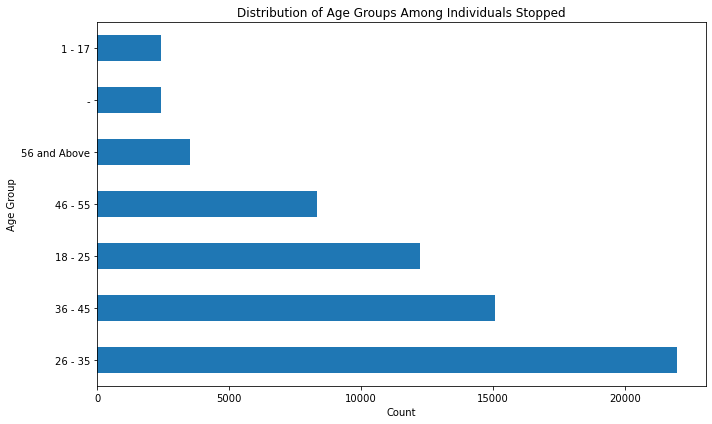

In [423]:
# A bar chart showing the distribution of age groups among the individuals stopped.
plt.figure(figsize=(10,6))
df_raw['Subject Age Group'].value_counts().plot(kind='barh')
plt.title('Distribution of Age Groups Among Individuals Stopped')
plt.xlabel('Count')
plt.ylabel('Age Group')
plt.tight_layout()
plt.show()

Race: The majority of subjects are perceived as White or Black or African American. There is a significant drop-off for other racial groups.

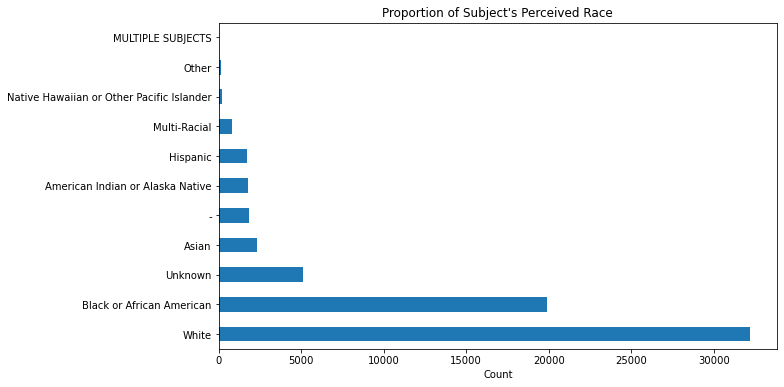

In [424]:
# A bar chart illustrating the proportion of subject's perceived race
plt.figure(figsize=(10, 6))
df_raw['Subject Perceived Race'].value_counts().plot(kind='barh')
plt.title('Proportion of Subject\'s Perceived Race')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

Stop Outcomes:

Resolution: The most common resolution is "Field Contact", followed by "Offense Report" and "Arrest". This confirms that most Terry Stops do not lead to an immediate booking.

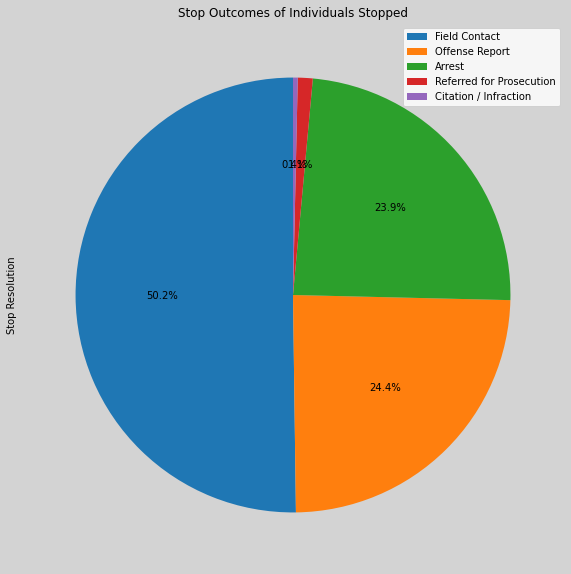

In [425]:
# A piechart chart showing the stop outcomes of the individuals stopped
plt.figure(figsize=(10, 10), facecolor = 'lightgrey')
df_raw['Stop Resolution'].value_counts().plot(kind='pie', labels = None, autopct='%1.1f%%', startangle=90)
plt.title('Stop Outcomes of Individuals Stopped')
plt.legend(labels=df_raw['Stop Resolution'].value_counts().index, loc="best")
plt.show()

3. **Key Relationships (Bivariate Analysis)**

Arrest Rates by Race:

This chart visualizes the proportion of stops that turn into arrests for each racial group. It allows you to check for potential disparities in outcomes once a stop has been initiated.


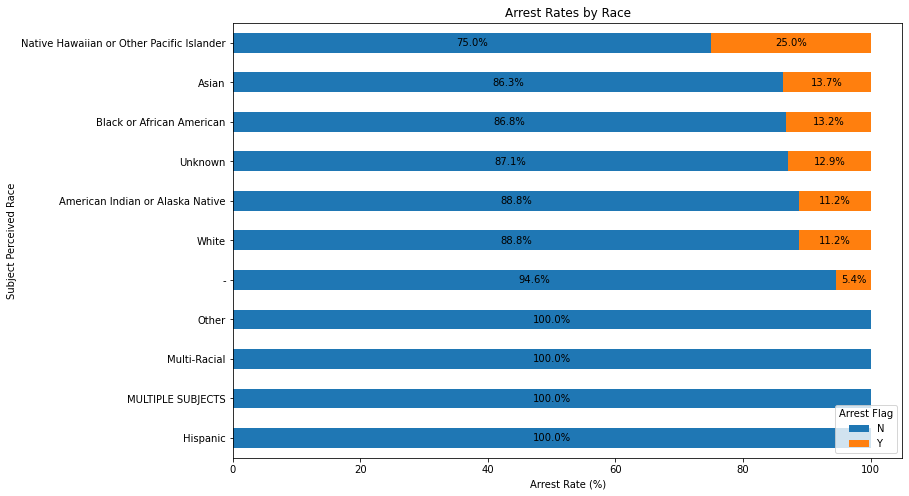

In [426]:
# A bar chart showing the Arrest rates by Race
race_arrest = pd.crosstab(df_raw['Subject Perceived Race'], df_raw['Arrest Flag'], normalize='index') * 100

# Sorting the indexes for better visualization
if 'Y' in race_arrest.columns:
    race_arrest = race_arrest.sort_values(by='Y', ascending=True)

plot = race_arrest.plot(kind='barh', figsize=(12, 8), stacked=True)
plt.title('Arrest Rates by Race')
plt.ylabel('Subject Perceived Race')
plt.xlabel('Arrest Rate (%)')
plt.legend(title='Arrest Flag', loc='lower right')

# Adding percentages to the bar chart
for bar in plot.patches:
    width = bar.get_width()
    if width > 5:  # Only show label if segment is large enough
        plt.text(bar.get_x() + width/2, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='center', va='center')
plt.show()



## **Data Preparation**


### 1. Missing values

In [427]:
# Checking for missing values in the dataset
df_raw.isnull().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Weapon Type                   0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               566
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
Occurred Date                 0
dtype: int64

With the `Officer Squad` having 566 missing values, it will be necessary to impute them with 'Unknown' instead of dropping them which might lead to loss of actual arrest cases.

In [428]:
# Imputing the `Officer Squad` with 'Unknown'
df_raw['Officer Squad'] = df_raw['Officer Squad'].fillna('Unknown')

### 2. Handling the many different placeholders

The `Weapon type` column has different placeholders to represent to weapon type present. The placeholders are `Nan`, `-` and `None` which all effectively mean the same thing; there was no Weapon. 

In [429]:
# Replacing NaNs and messy placeholder symbols with 'None' 
df_raw['Weapon Type'] = df_raw['Weapon Type'].fillna('None')
df_raw['Weapon Type'] = df_raw['Weapon Type'].replace(['-', 'None/Not Applicable'], 'None')

The `Subject Age Group` also has dashes with will be replaced with 'unknown' to represent that those age groups are not known 

In [430]:
df_raw['Subject Age Group'] = df_raw['Subject Age Group'].replace('-', 'Unknown')

The `Subject Perceived Race` has 'Unknown' and '-' entries which need to be standardized into one entry since they both mean the same thing.

It also has a single 'Multiple Subjects' entry that can also be categorised as multi-racial for analysis purposes. This is also more of an outlier.

In [431]:
df_raw['Subject Perceived Race'] = df_raw['Subject Perceived Race'].replace('-', 'Unknown')

# Replacing the outlier with Multi-Racial
df_raw['Subject Perceived Race'] = df_raw['Subject Perceived Race'].replace('MULTIPLE SUBJECTS', 'Multi-Racial')

The `Subject Perceived Gender` also has entries such as 'Unable to Determine', '-' and 'Unknown' which can easily be imputed into one entry as 'unknown'. The `Subject ID` also has an invalid entry of '-1' which needs to be imputed as 'Unknown'

In [432]:
df_raw['Subject Perceived Gender'] = df_raw['Subject Perceived Gender'].replace('-', 'Unknown')
df_raw['Subject Perceived Gender'] = df_raw['Subject Perceived Gender'].replace('Unable to Determine', 'Unknown')
df_raw['Subject Perceived Gender'] = df_raw['Subject Perceived Gender'].replace('MULTIPLE SUBJECTS', 'Unknown')

# Standardizing the 'Subject ID' column by replacing messy placeholder symbols with 'Unknown'
df_raw['Subject ID'] = df_raw['Subject ID'].replace(-1, 'Unknown')

The `Precinct` column has placeholders like '-', 'Unknown', 'OOJ' (Out of Jurisdiction) and 'FK ERROR' which can all be combined into one column 'Unknown'.
The `Sector` column also has '-' that need to be converted to 'Unknown'. Valid sectors are only single letter codes.
The `Beat` column also has messy placeholders. Valid beat entries should be two digit alphanumeric characters.

In [433]:
df_raw['Precinct'].value_counts()
df_raw['Precinct'] = df_raw['Precinct'].replace(['-', 'OOJ', 'FK ERROR'], 'Unknown')

# Standardizing the 'Sector' column by replacing messy placeholder symbols with 'Unknown'
df_raw['Sector'] = df_raw['Sector'].replace(['-', '99', 'OOJ'], 'Unknown')

# Standardizing the 'Beat' column by replacing messy placeholder symbols with 'Unknown'
df_raw['Beat'] = df_raw['Beat'].replace(['-', '99', 'OOJ', 'S'], 'Unknown')

# Standardizing the 'Initial Call Type' column by replacing messy placeholder symbols with 'Unspecified'
df_raw['Initial Call Type'] = df_raw['Initial Call Type'].replace('-', 'Unspecified')

# Standardizing the 'Final Call Type' column by replacing '-' with 'Unspecified'
df_raw['Final Call Type'] = df_raw['Final Call Type'].replace('-', 'Unspecified')

# Standardizing the 'Frisk Flag' column by replacing '-' symbol with 'Unspecified'
df_raw['Frisk Flag'] = df_raw['Frisk Flag'].replace('-', 'Unspecified')

### 3. Dealing with the varying datatypes

In [434]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65931 entries, 0 to 65930
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         65931 non-null  object
 1   Subject ID                65931 non-null  object
 2   GO / SC Num               65931 non-null  int64 
 3   Terry Stop ID             65931 non-null  int64 
 4   Stop Resolution           65931 non-null  object
 5   Weapon Type               65931 non-null  object
 6   Officer ID                65931 non-null  object
 7   Officer YOB               65931 non-null  int64 
 8   Officer Gender            65931 non-null  object
 9   Officer Race              65931 non-null  object
 10  Subject Perceived Race    65931 non-null  object
 11  Subject Perceived Gender  65931 non-null  object
 12  Reported Date             65931 non-null  object
 13  Initial Call Type         65931 non-null  object
 14  Final Call Type       

The `Reported Date` and the `Occurred Date` columns need to be converted into date values

In [435]:
# Converting 'Reported Date' to datetime format
df_raw['Reported Date'] = pd.to_datetime(df_raw['Reported Date'], errors='coerce')

# Converting 'Occurred Date' to datetime format
df_raw['Occurred Date'] = pd.to_datetime(df_raw['Occurred Date'], errors='coerce')

### 4. Feature Engineering

In [436]:
# Extracting the Hour, Month, DayOfWeek, and Year from the 'Occurred Date' column
df_raw['Hour'] = df_raw['Occurred Date'].dt.hour
df_raw['Month'] = df_raw['Occurred Date'].dt.month
df_raw['DayOfWeek'] = df_raw['Occurred Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df_raw['Year'] = df_raw['Occurred Date'].dt.year

In [437]:
# Creating Time Buckets to study how arrest rates vary throughout the day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night' # High risk for arrests

df_raw['Time_of_Day'] = df_raw['Hour'].apply(get_time_of_day)

In [438]:
# Creating a specific Weekend Flag where; 1=Weekend, 0=Weekday
df_raw['Is_Weekend'] = df_raw['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In order for the model to learn the time patterns and understand that hour 23 and 0 are close together, I decided to use Cyclical Encoding. This ensures these values become mathematically adjacent, allowing the model to learn "Late Night" patterns correctly.

In [439]:
# Mapping hours onto a circle so 23 and 0 are close neighbors.
df_raw['Hour_Sin'] = np.sin(2 * np.pi * df_raw['Hour'] / 24)
df_raw['Hour_Cos'] = np.cos(2 * np.pi * df_raw['Hour'] / 24)

# Mapping months onto a circle so Dec and Jan are close neighbors.
df_raw['Month_Sin'] = np.sin(2 * np.pi * df_raw['Month'] / 12)
df_raw['Month_Cos'] = np.cos(2 * np.pi * df_raw['Month'] / 12)

# Mapping days of the week onto a circle so Sat and Sun are close neighbors.
df_raw['DayOfWeek_Sin'] = np.sin(2 * np.pi * df_raw['DayOfWeek'] / 7)
df_raw['DayOfWeek_Cos'] = np.cos(2 * np.pi * df_raw['DayOfWeek'] / 7)

To calculate the age gaps between officer and the subject, I decided to use the median of the age groups as the ages of the individual. This makes the age gaps an approximate value and not completely the true value.

In [440]:
# Calculating the Officer's age at the time of the stop
df_raw['Officer Age'] = df_raw['Year'] - df_raw['Officer YOB']

                    # Age Difference (Generation Gap)

# Convert Subject Age Range to a single Number (Estimate)
def age_group(age_group):
    if age_group == '1 - 17': return 16
    if age_group == '18 - 25': return 21.5
    if age_group == '26 - 35': return 30.5
    if age_group == '36 - 45': return 40.5
    if age_group == '46 - 55': return 50.5
    if age_group == '56 and Above': return 60 
    return 30.5  # In the case of missing/unknown
df_raw['Subject_Age'] = df_raw['Subject Age Group'].apply(age_group)
df_raw['Age_Difference'] = df_raw['Officer Age'] - df_raw['Subject_Age']

Now to check whether the officer and the subject whether they belong to the same ethic background and gender

In [441]:
# Same Race Flag (1 = Match, 0 = Different) to check if the officer and subject share the same racial background
df_raw['Same_Race'] = (df_raw['Officer Race'] == df_raw['Subject Perceived Race']).astype(int)

# Same Gender Flag
df_raw['Same_Gender'] = (df_raw['Officer Gender'] == df_raw['Subject Perceived Gender']).astype(int)

Now to add a `Minority_Interaction` feature whereby to determine the if there exists patterns whereby more arrests were as a result of White officer stopping a non_white Subject.

In [442]:
# Minority Interaction Flag that specifically flags stops where a White Officer stops a Non-White Subject. This would help the model in bias analysis
df_raw['Subject_Is_White'] = df_raw['Subject Perceived Race'] == 'White'
df_raw['Officer_Is_White'] = df_raw['Officer Race'] == 'White'

df_raw['Minority_Interaction'] = ((df_raw['Officer_Is_White']) & (~df_raw['Subject_Is_White'])).astype(int)

### 5. Feature Selection

In [443]:
# Dropping the unnecessary columns
df = df_raw.drop(columns=['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Stop Resolution', 'Officer YOB', 'Reported Date', 'Final Call Type', 'Officer Squad', 'Officer ID', 'Beat', 'Occurred Date', 'Hour', 'Month', 'DayOfWeek'])
df

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Arrest Flag,Frisk Flag,...,DayOfWeek_Sin,DayOfWeek_Cos,Officer Age,Subject_Age,Age_Difference,Same_Race,Same_Gender,Subject_Is_White,Officer_Is_White,Minority_Interaction
0,1 - 17,None,Male,White,Black or African American,Male,OBS - FIGHT - IP - PHYSICAL (NO WEAPONS),911,N,N,...,-0.781831,0.623490,39,16.0,23.0,0,1,False,True,1
1,26 - 35,None,Male,White,Black or African American,Male,BURG - COMM BURGLARY,ONVIEW,N,N,...,-0.974928,-0.222521,42,30.5,11.5,0,1,False,True,1
2,56 and Above,None,Female,White,White,Male,ASLT - WITH OR W/O WPNS (NO SHOOTINGS),911,N,N,...,-0.433884,-0.900969,54,60.0,-6.0,1,0,True,True,0
3,26 - 35,None,Male,Hispanic,Hispanic,Male,Unspecified,-,N,N,...,-0.781831,0.623490,28,30.5,-2.5,1,1,False,False,0
4,36 - 45,None,Female,White,White,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,ONVIEW,N,N,...,-0.974928,-0.222521,28,40.5,-12.5,1,0,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65926,26 - 35,None,Male,White,Unknown,Male,SUICIDE - CRITICAL,911,N,Y,...,0.000000,1.000000,26,30.5,-4.5,0,1,False,True,1
65927,46 - 55,None,Female,White,White,Male,Unspecified,-,N,N,...,-0.974928,-0.222521,37,50.5,-13.5,1,0,True,True,0
65928,26 - 35,None,Female,White,White,Female,Unspecified,-,N,N,...,-0.433884,-0.900969,34,30.5,3.5,1,1,True,True,0
65929,26 - 35,None,Female,White,Unknown,Male,OBS - BURG - IP/JO - COMM BURG (INCLUDES SCHOOLS),911,N,N,...,-0.974928,-0.222521,50,30.5,19.5,0,0,False,True,1


### 6. Data Preprocessing

For the `Subject Age Group` I decided to use ordinal encoding to represent each age group. For the unknown age group, I decided to replace it with the age group with the highest mode.

In [444]:
# Replacing 'Unknown' in 'Subject Age Group' with the mode '26 - 35'
df['Subject Age Group'].replace({'Unknown': '26 - 35'}, inplace=True)

# Now to map the age groups to numerical values for modeling
age_group_mapping = {'1 - 17': 0, 
                     '18 - 25': 1,
                     '26 - 35': 2,
                     '36 - 45': 3,
                     '46 - 55': 4,
                     '56 and Above': 5}

df['Subject Age Group'] = df['Subject Age Group'].map(age_group_mapping)

For the following features, I perfomed One Hot encoding:

In [445]:
ohe_columns = ['Officer Gender', 'Officer Race', 'Subject Perceived Race','Subject Perceived Gender','Call Type', 'Precinct', 'Time_of_Day']
df1 = pd.get_dummies(df, columns=ohe_columns, drop_first=True)

Since the `Arrest flag` and the `Frisk flag` are binary, I decided to use binary encoding

In [446]:
# Replacing 'Unspecified' in 'Frisk Flag' with 'N' for better modeling
df1['Frisk Flag'].replace({'Unspecified': 'N'}, inplace=True)

#  Mapping the Arrest Flag to binary values
df1['Arrest Flag'] = df1['Arrest Flag'].map({'Y': 1, 'N': 0})

# Mapping the Frisk Flag to binary values
df1['Frisk Flag'] = df1['Frisk Flag'].map({'Y': 1, 'N': 0})

The remaining features: `Initial Call Type`, `Weapon Type` and `Sector` had alot of unique entries which if one-hot-encoded would lead to a lot of dimensions in the dataframe. As a result, I decided to use target encoding to sort this issue out. However, to prevent the risk of data leakage, I had to split the data into training and test data first.

In [447]:
# Setting up the variables
X = df1.drop('Arrest Flag', axis=1)
y = df1['Arrest Flag']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing the Encoder
encoder = TargetEncoder(target_type='binary', smooth='auto', cv=5)

# Applying it to the 3 columns
cols_to_encode = ['Initial Call Type', 'Sector', 'Weapon Type']

# Fitting on training data
X_train[cols_to_encode] = encoder.fit_transform(X_train[cols_to_encode], y_train)

# Transforming test data
X_test[cols_to_encode] = encoder.transform(X_test[cols_to_encode])
X_train.head()

,Subject Age Group,Weapon Type,Initial Call Type,Frisk Flag,Sector,Year,Is_Weekend,Hour_Sin,Hour_Cos,Month_Sin,...,"Call Type_TELEPHONE OTHER, NOT 911",Call Type_TEXT MESSAGE,Precinct_North,Precinct_South,Precinct_Southwest,Precinct_Unknown,Precinct_West,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night
61030,2,0.106594,0.203744,0,0.123331,2023,0,5.000000e-01,-0.866025,1.000000e+00,...,0,0,0,0,0,0,1,0,1,0
12773,4,0.106575,0.192866,0,0.138763,2015,0,-8.660254e-01,-0.500000,-5.000000e-01,...,0,0,0,0,1,0,0,0,0,0
23760,2,0.106594,0.182840,1,0.140005,2021,1,8.660254e-01,-0.500000,1.224647e-16,...,0,0,0,1,0,0,0,0,1,0
14084,1,0.106575,0.074774,0,0.122721,2024,0,1.224647e-16,-1.000000,-5.000000e-01,...,0,0,0,0,0,0,1,0,0,0
18216,2,0.106575,0.232758,0,0.142396,2023,1,-9.659258e-01,-0.258819,1.224647e-16,...,0,0,0,0,1,0,0,1,0,0


Perfoming standard scaling to ensure no single feature dominates due to its numerical range hence better model performance and interpretability.

In [448]:
numerical_features = ['Age_Difference', 'Officer Age', 'Subject_Age', 'Year']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

## **Modelling**

### **1. The baseline model**

[Terry Stops Dataset](Data/Terry_Stops_20251229.csv) is an imbalanced Dataset whereby my target variable `Arrest Flag` has (89% No Arrests, 11% Arrests). If my model was lazy and just predicted "No Arrest" for every single person, it would be 89% accurate. This sets the baseline that my models should be above 89% in accuracy to consider them a viable model to proceed with.

My baseline model is thus a model that makes the same guess for all entries using the 'most frequent strategy'

In [449]:
# The Dummy Classifier 
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print(classification_report(y_test, y_pred_dummy, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11674
           1       0.00      0.00      0.00      1513

    accuracy                           0.89     13187
   macro avg       0.44      0.50      0.47     13187
weighted avg       0.78      0.89      0.83     13187



This baseline model however, doesn't learn anything since it merely guesses based on "always predict no arrest". It ignores all the features and just predicts based on the target's distribution giving me no insight into why an arrest happens. 

This model displays good accuracy but this is deceptive due to the class imbalance has a terrible precision score of 0.00 hence it never predicts arrests and also misses 100% of actual arrests. It is therefore currently non-viable when predicting arrests.

### **2. Logistic Regression**

With logistic regression, the model will be able to actively learn the relationship between the features my target variable. It will thus use the data to make informed predictions.

In [450]:
# Initializing the regressor
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Fitting the model
log_reg.fit(X_train, y_train)

# Predicting using the test data
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'ROC-AUC: {roc_auc}')

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     11674
           1       0.26      0.77      0.39      1513

    accuracy                           0.72     13187
   macro avg       0.61      0.74      0.60     13187
weighted avg       0.88      0.72      0.77     13187

ROC-AUC: 0.8190012694503839


The model can now identify 77% of potential arrests unlike the baseline model which only identified about 0% of the arrests. It also has a better precision that the baseline model of 96% of the time. This model has a lower overall accuracy compared to the baseline model but it is much more useful. This model is now practically useful to the stakeholders. The ROC-AUC score of 81.9% also validates that the model has a strong predictive power for distuinguishing arrest outcomes hence can effectively rank Terry stops by arrest likelihood

From this model, I was also able to identify the features that mostly lead to a formal arrest:

In [451]:
# Analysing the features
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg.coef_[0]})
print(coef_df.sort_values(by='Coefficient', ascending=False).head(10))

                                              Feature  Coefficient
2                                   Initial Call Type     7.016285
1                                         Weapon Type     4.003253
4                                              Sector     3.805284
22                       Officer Gender_Non-Specified     2.230351
29                               Officer Race_Unknown     1.138667
0                                   Subject Age Group     1.027550
5                                                Year     1.023038
48                             Call Type_TEXT MESSAGE     0.771395
26                              Officer Race_Hispanic     0.466023
27  Officer Race_Native Hawaiian or Other Pacific ...     0.443941


`Initial Call Type` dominates with a huge coefficient in arrest likelihood, followed by `Sector` and `Weapon Type` as other strong secondary factors. Thus, situational factors outweigh subject characteristics in predicting arrest outcomes.

### **3. Random Forest**

In [452]:
# Initializing the Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Uses all CPU cores for faster training
)

# Fitting the model
rf_model.fit(X_train, y_train)

# Predicting using the test data
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluating the model
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC-AUC Score: 0.8654

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83     11674
           1       0.29      0.86      0.43      1513

    accuracy                           0.74     13187
   macro avg       0.63      0.79      0.63     13187
weighted avg       0.90      0.74      0.78     13187



This Random forest model finds 87% of actual arrests and predicts arrest, when it's right 29% of the time. The ROC-AUC of 86.7% also shows excellent discriminative ability. It actually performs slightly better overrally than the Logistic Regression.

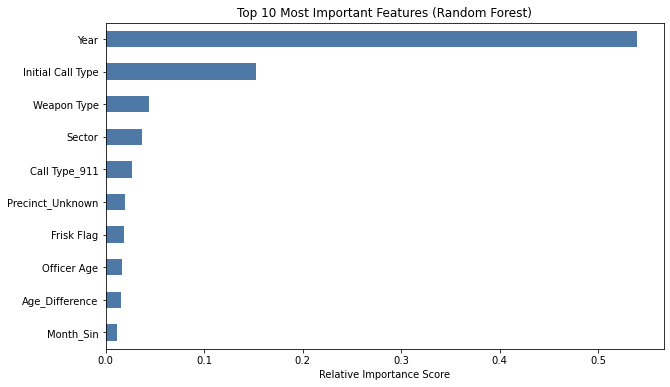

In [453]:
# Visualizing Feature Importance
if hasattr(X_train, 'columns'):
    feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
    
    # Plotting top 10 features
    plt.figure(figsize=(10, 6))
    feat_importances.nlargest(10).sort_values().plot(kind='barh', color='#4e79a7')
    plt.title('Top 10 Most Important Features (Random Forest)')
    plt.xlabel('Relative Importance Score')
    plt.show()
else:
    print("Skipping plot: X_train has no column names.")

In this model `Year` is the most important feature in determining arrest likelihood. This can be attributed to maybe a policy change over the years hence more arrests.

### **4. Gradient Boosting Classifier**

Gradient Boosting Classifier perfoms better for tabular data which has mixed categories and imbalanced classes than Random forest hence being a viable option to test.

In [454]:
# Initializing the Model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

# Fitting the model
gb_model.fit(X_train, y_train)

# Predict
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)[:, 1]

# Evaluating the model
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC-AUC Score: 0.8743

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     11674
           1       0.60      0.04      0.08      1513

    accuracy                           0.89     13187
   macro avg       0.75      0.52      0.51     13187
weighted avg       0.86      0.89      0.84     13187



Gradient Boost Classifier finds all non-arrests but this is easy with imbalance and has a precision of 89% which coincidentally matches class distribution.